# 3.1 Linear Regression

*Regression*: modeling the relationship between one or more independent variables and a dependent variable. 

## Linear Model

The linearity assumption says that the dependent variable can be expressed as  a weighted sum of features + a bias term. 
\begin{equation}
\hat{y} = \sum_{i=1}^n w_ix_i + b
\end{equation}
Or, letting $\mathbf{w}$ be a vector of the weights and $\mathbf{X}$ a *design matrix* (where each row is a training example, each column is a feature, and we add a column of 1s) 
\begin{equation}
\mathbf{\hat{y}} = \mathbf{Xw}. 
\end{equation}

## Loss Function 
The loss function is given by 
\begin{equation}
L(\mathbf{w}) = \frac{1}{2n}||\mathbf{y}-\mathbf{Xw}||^2
\end{equation}
The goal of training is to find 
\begin{equation}
\mathbf{w}^* = \mathrm{arg min}_\mathbf{w}L(\mathbf{w})
\end{equation}

This loss function specifies the MLE given the assumption of Gaussian noise. Assume that
\begin{equation}
y = \mathbf{w}^T\mathbf{x} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, \sigma^2)
\end{equation}
We want to maximize 
\begin{equation}
p(\mathbf{y}|\mathbf{X}) = \prod p(y^{(i)}\mid \mathbf{x}^{(i)})
\end{equation}
In practice, it is easier to optimize the log-likelihood, and by convention we want to minimize rather than maximize, therefore we take the negative log-likelihood. 
\begin{equation}
-\log P(\mathbf{y}\mid\mathbf{X}) = \frac{n}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}||\mathbf{y} - \mathbf{Xw}||^2. 
\end{equation}
Dropping everything that's independent of $\mathbf{w}$, we get the loss function. 

## Analytic Solution
Linear regression is one of the rare optimization problems with an analytic solution. 
\begin{equation}
\mathbf{w}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}.
\end{equation}

## Minibatch Stochastic Gradient Descent

Almost every optimization algorithm used in deep learning is some variation of minibatch stochastic gradient descent. 

The basic idea of gradient descent is to find minima using the following iterative process 
\begin{equation}
\mathbf{w}_{i+1} = \mathbf{w}_i - \eta\nabla_\mathbf{w}L(\mathbf{w})
\end{equation}
Where $\eta$ is a hyperparameter called the *learning rate*. 

But computing $\nabla_\mathbf{w}L(\mathbf{w})$ on each iteration is costly. Therefore, on each iteration, we sample a minibatch $\mathcal{B}$ and estimate $\nabla_\mathbf{w}L(\mathbf{w})$ using only the examples in $\mathcal{B}$. The size of the minibatches is another hyperparameter. 

For notational convenience, let 
\begin{equation}
l^{(i)}(\mathbf{w}) = \frac{1}{2}(\mathbf{\hat{y}}^{(i)}-\mathbf{y}^{(i)})^2
\end{equation}
Then
\begin{equation}
L(\mathbf{w}) = \frac{1}{n}\sum l^{(i)}(\mathbf{w})
\end{equation}
Then minibatch stochastic gradient descent works as follows
\begin{equation}
\mathbf{w}_{i+1} = \mathbf{w}_i - \frac{\eta}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}\partial_w l^{(i)}(\mathbf{w}) = \mathbf{w}_i - \frac{\eta}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}\mathbf{x}^{(i)}\left(\mathbf{w}^T\mathbf{x}^{(i)} - \mathcal{y}^{(i)}\right)
\end{equation}

## Vectorization
Consolidating costly `for` loops into fast matrix operations can speed up our code dramatically. 

# Implementation 

In [1]:
import torch 
import random 
import matplotlib.pyplot as plt 

### Data
We first generate synthetic data. 

In [2]:
def synthetic_data(w, num_examples): 
    X = torch.normal(0, 1, (num_examples, len(w) - 1))
    ones = torch.ones((num_examples, 1))
    X = torch.cat((ones, X), dim=1)
    y = torch.matmul(X, w) 
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([4.2, 2, -3.4])

features, labels = synthetic_data(true_w, 1000)

Visualization of the linear correlation between $y$ and $x_1$. 

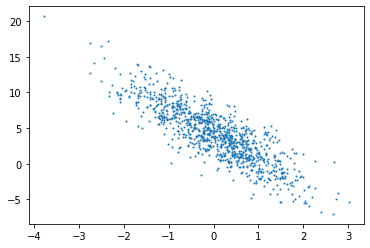

In [3]:
plt.scatter(features[:, 2].numpy(), labels.numpy(), 1)

### Batching

Creates an iterable for minibatching. In practice, we want large minibatches to exploit parallelism. 

In [4]:
def data_iter(batch_size, features, labels): 
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): 
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels): 
    print(torch.cat((X, y), dim=1))
    break

tensor([[ 1.0000,  1.2131,  1.7047,  0.8355],
        [ 1.0000, -1.3691, -0.1269,  1.9027],
        [ 1.0000, -1.5180,  1.8054, -4.9715],
        [ 1.0000,  0.0821, -0.8942,  7.4092],
        [ 1.0000, -1.1560, -0.9046,  4.9586],
        [ 1.0000, -1.3528,  1.1894, -2.5501],
        [ 1.0000,  0.4905, -0.5693,  7.1054],
        [ 1.0000, -0.7782, -0.7976,  5.3427],
        [ 1.0000,  0.4764, -0.7417,  7.6737],
        [ 1.0000, -0.3064, -0.4127,  4.9992]])


Generate initial values for weights. 

In [5]:
w = torch.normal(0, 0.01, size = (3,1), requires_grad=True)
print(w)

tensor([[ 0.0052],
        [ 0.0051],
        [-0.0093]], requires_grad=True)


In [6]:
# Prediction function
def linreg(X, w): 
    return torch.matmul(X, w)

# Loss function
def squared_loss(y_hat, y): 
    return (y_hat - y) ** 2 / 2 

In [7]:
# sgd
def sgd(params, lr, batch_size): 
    with torch.no_grad():
        params -= lr * params.grad / batch_size
        params.grad.zero_()

Main training loop: 

In [8]:
lr = 0.03
num_epochs = 3
net = linreg 
loss = squared_loss 


w = torch.normal(0, 0.01, size = (3,1), requires_grad=True)
print("w = \n", w)

for epoch in range(num_epochs): 
    for X, y in data_iter(batch_size, features, labels): 
        l = loss(net(X, w), y)
        l.sum().backward()
        sgd(w, lr, batch_size)
    with torch.no_grad(): 
        train_l = loss(net(features, w), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    print("w = \n", w)

            

w = 
 tensor([[0.0003],
        [0.0158],
        [0.0030]], requires_grad=True)
epoch 1, loss 0.042364
w = 
 tensor([[ 3.9969],
        [ 1.9199],
        [-3.1999]], requires_grad=True)
epoch 2, loss 0.000165
w = 
 tensor([[ 4.1907],
        [ 1.9965],
        [-3.3878]], requires_grad=True)
epoch 3, loss 0.000050
w = 
 tensor([[ 4.2001],
        [ 1.9995],
        [-3.3986]], requires_grad=True)


In [9]:
# Error from true parameters
print("Error in estimating w: ", (true_w - w.reshape(true_w.shape)).norm())


Error in estimating w:  tensor(0.0015, grad_fn=<CopyBackwards>)


# Implementation using high-level API
Modern deep learning frameworks provide a tremendous amount of automation. 

In [10]:
import numpy as np
from torch.utils import data
from torch import nn

# Discard the column of ones.
features2 = features[:, 1:]
print(features2)

tensor([[-0.0436,  1.5685],
        [ 1.0506, -0.0539],
        [-1.0695,  0.2334],
        ...,
        [ 0.6333, -0.3347],
        [ 0.5646, -0.2069],
        [ 0.6530, -2.0888]])


In [11]:
# Constructs a PyTorch data iterator
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10

data_iter = load_array((features2, labels), batch_size)
print(data_iter)

In [12]:
next(iter(data_iter))

[tensor([[-0.7709, -1.7309],
         [-1.6253,  0.6268],
         [-0.5295,  0.4740],
         [-1.3796, -1.0639],
         [ 2.5633,  0.3100],
         [-0.7603, -0.2150],
         [ 0.6449,  1.4843],
         [-0.0240,  0.2031],
         [ 0.6170,  0.3315],
         [-0.4490,  0.5956]]),
 tensor([[ 8.5485],
         [-1.1704],
         [ 1.5159],
         [ 5.0392],
         [ 8.2753],
         [ 3.4158],
         [ 0.4368],
         [ 3.4495],
         [ 4.3073],
         [ 1.2972]])]

Defining the model

In [13]:
net = nn.Sequential(nn.Linear(2, 1))

In [14]:
# Initializing model parameters
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [15]:
# MSE loss
loss = nn.MSELoss()

The Pytorch `optim` module contains stochastic gradient descent and a bunch of variations. 

In [16]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

The training loop has a similar logic To the manual implementation

In [17]:
num_epochs = 3
for epoch in range(num_epochs): 
    for X, y in data_iter: 
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features2), labels)
    print("epoch ", epoch, ", loss ", float(l))

epoch  0 , loss  0.00028297503013163805
epoch  1 , loss  0.00010014433064498007
epoch  2 , loss  0.00010028117685578763


These high-level features become especially useful when we start dealing with complicated networks. 